In [1]:
!pip install --upgrade -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 13.3 MB/s eta 0:00:00
   ━━━

In [2]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

In [4]:
# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

In [5]:
### Router
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model
class RouteQuery(BaseModel):
  """Route a user query to the most relevant datasource."""

  datasource: Literal["vectorstore", "wiki_search"] = Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore."
  )

from google.colab import userdata
from langchain_groq import ChatGroq
import os

groq_api_key = userdata.get('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)


# prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)

question_router = route_prompt | structured_llm_router

print(
    question_router.invoke(
        {"question":"Who is Deepika Padukon?"}
    )
)

print(question_router.invoke({"question": "Waht are the types of agent memory?"}))


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


datasource='wiki_search'
datasource='vectorstore'


In [6]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
  """Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(
      description="Documents are relevant to the question, 'yes' or 'no'"
  )

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

<ipython-input-6-7a6d9d1207a1>:28: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='no'


In [7]:
# Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print(prompt)

#LLM
# llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")

# Post-processing
def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)


/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]
Long-term memory in an LLM-powered agent system is responsible for retaining and recalling information over extended periods.  It often uses an external vector store and fast retrieval methods to achieve this.  



In [8]:
# Hallucination Gender

# Data model
class GradeHallucinations(BaseModel):
  """Binary score for hallucination present in generation answer."""

  binary_score: str = Field(
      description = "Answer is grounded in the facts, 'yes' or 'no'"
  )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
 Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in  / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

formatted_docs = format_docs(docs)
hallucination_grader.invoke({"documents": formatted_docs, "generation": generation})

GradeHallucinations(binary_score='no')

In [9]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
  """Binary score to access answer addresses question."""

  binary_score: str = Field(
      description = "Answer addresses the question, 'yes' or 'no'"
  )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
            ("system", system),
            ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)


answer_grader = answer_prompt | structured_llm_grader

answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [10]:
!pip install langchain_community arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.3 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=6504972608869f68fbe40fd371cd239b8c3163a25e66ea07e2a05b2bba0e7b6f
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=ad03fb1151f09c7482698c519766d6e65e92718bcf86e376e6092cf7dcb987cb
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [11]:
# Prompt
system = """You are a question re-writter that converts an input question to a better version that is optimized \n
 for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human",
         "Here is the initial question: \n\n {question} \n Formulate only one improved question.")
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

"How does an agent's memory function? \n"

In [12]:
## Working with Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

# Arxiv and wikipedia Tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

In [13]:
wiki.invoke("What is Machine Learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and gen'

In [14]:
## Graph


from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
    question: question
    generation: LLM generation
    documents: list of documents
  """

  question: str
  generation: str
  documents: List[str]

In [15]:
from langchain.schema import Document


def retrieve(state):
  """
  Retrieve documents

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, documents, that contains retrieved documents
  """
  print("---RETRIEVED---")
  question = state['question']

  # Retrieval
  documents = retriever.invoke(question)
  return {"documents": documents, "question": question}


def generate(state):
  """
  Generate answer

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation

  """
  print("---GENERATE---")
  question = state['question']
  documents = state['documents']

  # RAG generation
  generation = rag_chain.invoke({"context": documents, "question": question})
  return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
  """
  Determines whether the retrieved documents are relevant to the question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates documents key with only filtered relevant documents
  """

  print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
  question = state['question']
  documents = state['documents']

  # Score each doc
  filtered_docs = []
  for d in documents:
    score = retrieval_grader.invoke(
        {"question": question, "document": d.page_content}
    )
    grade = score.binary_score
    if grade == "yes":
      print("---GRADE: DOCUMENT RELEVANT---")
      filtered_docs.append(d)
    else:
      print("---GRADE: DOCUMENT NOT RELEVANT---")
      continue

    return {"documents": filtered_docs, "question": question}


def transform_query(state):
  """
  Transform the query to produce a better question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates question key with re-phrased question
  """

  print("---TRANSFORM QUERY---")
  question = state['question']
  documents = state['documents']

  #Re-write question
  better_question = question_rewriter.invoke({"question": question})
  return {"documents": documents, "question": better_question}


def wiki_search(state):
  """
  wiki search based on the re-phrased question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates question key with appended web results
  """

  print("---WIKI SEARCH---")
  print("---HELLO---")
  question = state['question']
  print(question)

  # wiki search
  docs = wiki.invoke({"query": question})
  wiki_results = docs
  wiki_results = Document(page_content=wiki_results)

  return {"documents": wiki_results, "question": question}


### Edges ###


def route_question(state):
  """
  Route question to wiki search or RAG

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Next node to call
  """

  print("---ROUTE QUESTION---")
  question = state['question']
  source = question_router.invoke({"question": question})
  if source.datasource == "wiki_search":
    print("---ROUTE QUESTION TO WIKI SEARCH---")
    return "wiki_search"
  elif source.datasource == "vectorstore":
    print("---ROUTE QUESTION TO RAG---")
    return "vectorstore"


def decide_to_generate(state):
  """
  Determines whether to generate an answer, or re-generate a question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Binary decision for next node to call
  """

  print("---ACCESS GRADED DOCUMENTS---")
  question = state['question']
  filtered_documents = state['documents']

  if not filtered_documents:
    # All documents have been filtered check_relevance
    # We will re-generate a new query
    print(
        "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
    )
    return "transform_query"
  else:
    print("---DECISION: GENERATE---")
    return "generate"


def grade_generation_v_documents_and_question(state):
  """
  Determines whether the generation is grounded in the document and answers question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Decision for next node to call
  """

  print("---CHECK HALLUCINATIONS---")
  question = state['question']
  generation = state['generation']
  documents = state['documents']

  score = hallucination_grader.invoke(
      {"documents": documents, "generation": generation}
  )
  grade = score.binary_score
  if grade == "yes":
      print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
      # Check question-answering
      print("---GRADE GENERATION vs QUESTION---")
      score = answer_grader.invoke({"question": question, "generation": generation})
      grade = score.binary_score
      if grade == "yes":
          print("---DECISION: GENERATION ADDRESSES QUESTION---")
          return "useful"
      else:
          print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
          return "not useful"
  else:
      print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
      return "not supported"

In [17]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("wiki_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)

workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not useful": "transform_query",
        "not supported": "generate"
    },
)


# compile
app = workflow.compile()

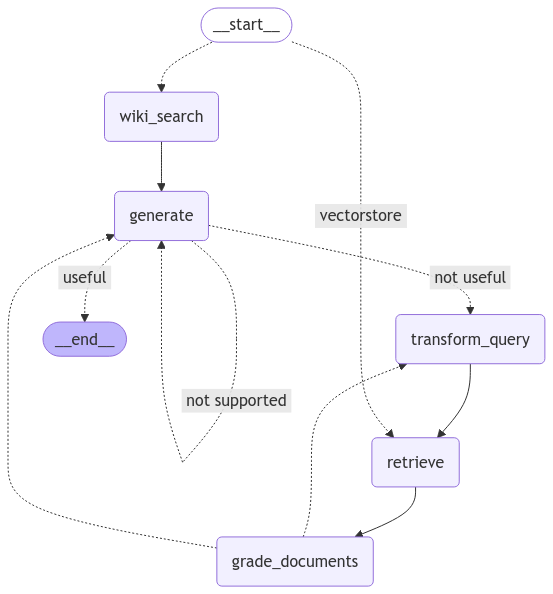

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
from pprint import pprint

# Run
inputs = {
    "question": "Tell me about Sharukh Khan?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WIKI SEARCH---
---WIKI SEARCH---
---HELLO---
Tell me about Sharukh Khan?
"Node 'wiki_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Shah Rukh Khan is an Indian actor and film producer known for his work in '
 'Hindi cinema.  He is also known by the initialism SRK. Khan was born on '
 'November 2, 1965.  \n')


In [23]:
inputs = {"question": "What are the types of agent memory?"}

for output in app.stream(inputs):
  for key, value in output.items():
    pprint(f"Node '{key}':")

  pprint("\n--\n")

pprint(value["generation"])



---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVED---
"Node 'retrieve':"
'\n--\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ACCESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n--\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n--\n'
('The context describes two types of agent memory: short-term memory and '
 'long-term memory.  Short-term memory is considered to be in-context '
 'learning, while long-term memory is used to retain and recall information '
 'over extended periods, often by leveraging an external vector store.  \n')
